In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
PATH = "datasets/Kaggle_HPA_2018/"
data_path = Path(PATH)

In [4]:
NUM_CLASSES = 27
bs = 64
sz = [4,224,224]

In [5]:
# setting up a list of a random 20% of images in train as the validation set

lbl_csv = PATH + 'train_10perc_v2.csv'
n = len(list(open(lbl_csv))) -1
val_idxs = get_cv_idxs(n)

In [6]:
def get_data(path, lbl_csv, val_idxs, sz, bs, aug_tfms):
    
    augs = [RandomDihedral()
           ]

    tfms = tfms_with_IntNorm(sz, aug_tfms=aug_tfms, crop_type=CropType.CENTER)
    data = ImageClassifierData.from_csv(PATH, 'rand_10perc_v2_all_chan', lbl_csv, val_idxs = val_idxs,tfms=tfms, bs=bs, suffix = '.tiff')
    
    return data

In [7]:
# define augmentations
augs = [RandomDihedral()]

# initialize data object
data = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs)

### inpsect data_loaders

In [8]:
x, y = next(iter(data.trn_dl))

In [9]:
def to_label(y):
    ind = [i for i, p in enumerate(y) if y[i]==1]
    return(ind)

[24]


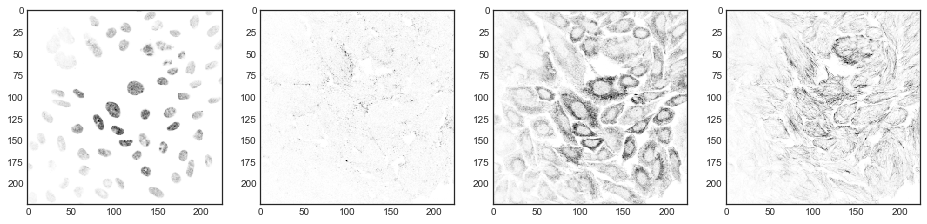

In [10]:
# inspect images
plt.style.use('seaborn-white')

idx = 2

im = to_np(x)[idx]

lbl = to_label(to_np(y)[idx])
print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

# training

In [11]:
# base-model

arch = resnet18_c
learn = ConvLearner.pretrained(arch, data, ps=0.25, opt_fn=optim.Adam, pretrained=False)

In [12]:
# additional parameters

wd=1e-5 # weight-decay/L2 regularization 
learn.metrics = [accuracy_thresh(0.5),f1_micro,f1_macro]

In [13]:
learn.unfreeze()

In [14]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 4, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 12544)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 5

In [15]:
learn.lr_find()

EPOCH 0 ---------------------------------------- STEP 0                                                                                                                                                                                      
epoch      trn_loss   val_loss   <lambda>   f1_micro   f1_macro   
    0      1.472508   4.928991   0.821614   0.252147   0.060684  



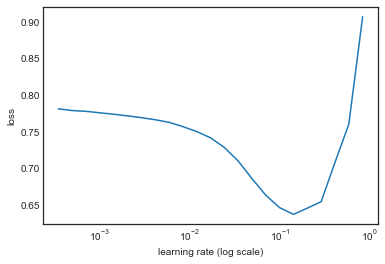

In [16]:
learn.sched.plot()

In [ ]:
# training loops:

In [18]:
%time learn.fit(1e-2, 8, cycle_len=1, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 1                                                                                                                                                                                      
epoch      trn_loss   val_loss   <lambda>   f1_micro   f1_macro   
    0      0.185966   0.189835   0.94185    0.309501   0.02518   
EPOCH 1 ---------------------------------------- STEP 2                                                                                                                                                                                      
    1      0.185898   0.182891   0.943162   0.290347   0.039785  
EPOCH 2 ---------------------------------------- STEP 3                                                                                                                                                                                      
    2      0.180536   0.171527   0.945011   0.309092   0.03928   
EPOCH 3 -------------

[array([0.16919]),
 0.9457267264621078,
 0.31137893396019234,
 0.043969920649423754]

In [ ]:
# eval

In [ ]:
log_preds, y = learn.predict_with_targs()

In [ ]:
# List of label identities:

cell_location_label = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }